In [5]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import emoji

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

# stemmer Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [6]:
# Read datasets
df = pd.read_excel('laundry_reviews_dataset.xlsx')
df.head()

,review_rating,review_text
0,5,akhirnya bisa nemu laundry yang bisa antar jem...
1,5,Layanan yang sangat baik dan kualitas yang bai...
2,5,Ok hasil kerja cuciannya bagus dan bersih wang...
3,1,1 Baju stel perempuan harga 900 ribu merek Mis...
4,1,"Cuci disini, baju yang tadinya bagus, malah ja..."


In [7]:
# Preprocessing
## Drop all columns except review_text
df.dropna(subset=['review_text'], inplace=True)

df['review_text'] = df['review_text'].str.lower()
df['review_text'] = df['review_text'].astype(str)
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r"\d+", "", x))
df['review_text'] = df['review_text'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
df['review_text'] = df['review_text'].str.strip()
df['review_text'] = df['review_text'].apply(lambda x: re.sub('\s+', ' ', x))
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'[\u2070-\u209F\u00B2-\u00B3\u00B9-\u00BF\u02B0-\u036F\u1AB0-\u1AFF\u2090-\u2094]+', '', x))

df['review_text'] = df['review_text'].apply(lambda x: emoji.demojize(x))

df['review_text'] = df['review_text'].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))))
df['review_text'] = df['review_text'].str.strip()
df['review_text'] = df['review_text'].apply(lambda x: re.sub('\s+', ' ', x))

df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'[^\u0000-\u007F\uD800-\uDBFF\uDC00-\uDFFF]+', '', x))

df['review_text'][0]

'akhirnya bisa nemu laundry yang bisa antar jemput barokalloh nuhun suka cuci'

In [8]:
# Assign label to negative and positive reviews
df['labels'] = df.review_rating.apply(lambda x: 0 if x in [1, 2, 3] else 1)
df.head()

# Check each label total reviews data
lenNegSentiment = df['labels'].value_counts()[0]
lenPosSentiment = df['labels'].value_counts()[1]
print("Count of 0 (Negative) sentiment:", lenNegSentiment)
print("Count of 1 (Positive) sentiment:", lenPosSentiment)

Count of 0 (Negative) sentiment: 1002
Count of 1 (Positive) sentiment: 1197


In [9]:
# # Balancing Negative and Positive Reviews

# posData = df[df['labels'] == 1]
# negData = df[df['labels'] == 0]

# randPosData = posData.sample(n=1000, random_state=40)
# randNegData = negData.sample(n=1000, random_state=40)

# randCombinedData = pd.concat([randPosData, randNegData])

# df = df.loc[randCombinedData.index]
# df['review_text'] = randCombinedData['review_text']

# lenNegSentiment = df['labels'].value_counts()[0]
# lenPosSentiment = df['labels'].value_counts()[1]
# print("Count of 0 (Negative) sentiment:", lenNegSentiment)
# print("Count of 1 (Positive) sentiment:", lenPosSentiment)

In [10]:
# define the required variabel for preprocessing
vocab_size = 5000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
training_split = 0.8

In [11]:
df_preproccessing = df.copy()

In [12]:
# create function for remove stop_words 
def remove_stopwords(sentences, stopwords):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
        stopwords (list) : list stopwrods
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    
    # Sentence converted to lowercase-only
    sentence = sentences.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [13]:
# create function for split data
def train_val_split(sentences, labels, size_training_split):
    
    train_size = round(len(sentences) * size_training_split)

    # training dataset
    training_reviews = sentences[:train_size]
    training_labels =  labels[:train_size]

    # validations data
    validation_review = sentences[train_size:]
    validation_labels = labels[train_size:]

    return training_reviews, validation_review, training_labels, validation_labels

In [14]:
# Split training and testing
sentences = df_preproccessing['review_text']
labels = df_preproccessing['labels']
train_sentences, test_sentences, train_labels, test_labels = train_val_split(sentences, labels, training_split)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(test_sentences)} sentences for validation.\n")
print(f"There are {len(test_labels)} labels for validation.")

There are 1759 sentences for training.

There are 1759 labels for training.

There are 440 sentences for validation.

There are 440 labels for validation.


In [15]:
# read file stopwords.txt and convert into list stopwords
my_file = open("stopword_tweet_pilkada_DKI_2017.csv", "r")
  
# reading the file
data = my_file.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
stopwords = data.split("\n")

print(len(stopwords))

785


In [16]:
# remove stopwords 
train_sentences = train_sentences.apply(lambda x: remove_stopwords(x, stopwords))

In [17]:
print("before drop stopwords : ", df_preproccessing['review_text'][4])
print("after drop stopwords : " , train_sentences[4])

before drop stopwords :  cuci disini baju yang tadinya bagus malah jadi bercak hitam saya tunggu ganti ruginya
after drop stopwords :  cuci baju bagus bercak hitam tunggu ganti ruginya


In [18]:
# Preprocessing Stemming 
factory = StemmerFactory()
stemmer = factory.create_stemmer()

train_sentences = train_sentences.apply(lambda x: stemmer.stem(x))


In [19]:
print("The review before stemmer : ", df_preproccessing['review_text'][4])
print("The review after stemmer : ", train_sentences[4])

The review before stemmer :  cuci disini baju yang tadinya bagus malah jadi bercak hitam saya tunggu ganti ruginya
The review after stemmer :  cuci baju bagus bercak hitam tunggu ganti rugi


In [20]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 5125 words

<OOV> token included in vocabulary


In [21]:
trainSequences = tokenizer.texts_to_sequences(train_sentences)
trainPadded = pad_sequences(trainSequences, maxlen=max_length, padding=padding_type , truncating=trunc_type)

testSequences = tokenizer.texts_to_sequences(test_sentences)
testPadded = pad_sequences(testSequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           80000     
                                                                 
 dropout (Dropout)           (None, 120, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [23]:
trainingLabelsArr = np.array(train_labels)
testingLabelsArr = np.array(test_labels)

num_epochs = 100
history = model.fit(trainPadded, trainingLabelsArr, epochs=num_epochs, validation_data=(testPadded, testingLabelsArr))

Epoch 1/100
55/55 [==============================] - 3s 12ms/step - loss: 0.8460 - accuracy: 0.6805 - val_loss: 1.0772 - val_accuracy: 0.0000e+00
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.7010 - accuracy: 0.6805 - val_loss: 1.1300 - val_accuracy: 0.0000e+00
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.6476 - accuracy: 0.6805 - val_loss: 1.1153 - val_accuracy: 0.0000e+00
Epoch 4/100
55/55 [==============================] - 0s 5ms/step - loss: 0.6227 - accuracy: 0.6805 - val_loss: 1.0849 - val_accuracy: 0.0386
Epoch 5/100
55/55 [==============================] - 0s 6ms/step - loss: 0.6063 - accuracy: 0.6868 - val_loss: 1.0278 - val_accuracy: 0.1000
Epoch 6/100
55/55 [==============================] - 0s 6ms/step - loss: 0.5863 - accuracy: 0.7010 - val_loss: 0.9515 - val_accuracy: 0.2136
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.5623 - accuracy: 0.7197 - val_loss: 0.8347 - val_accuracy: 0.3227


In [24]:
model.evaluate(testPadded, testingLabelsArr)

14/14 [==============================] - 0s 2ms/step - loss: 0.0841 - accuracy: 0.9682


[0.08408921211957932, 0.9681817889213562]

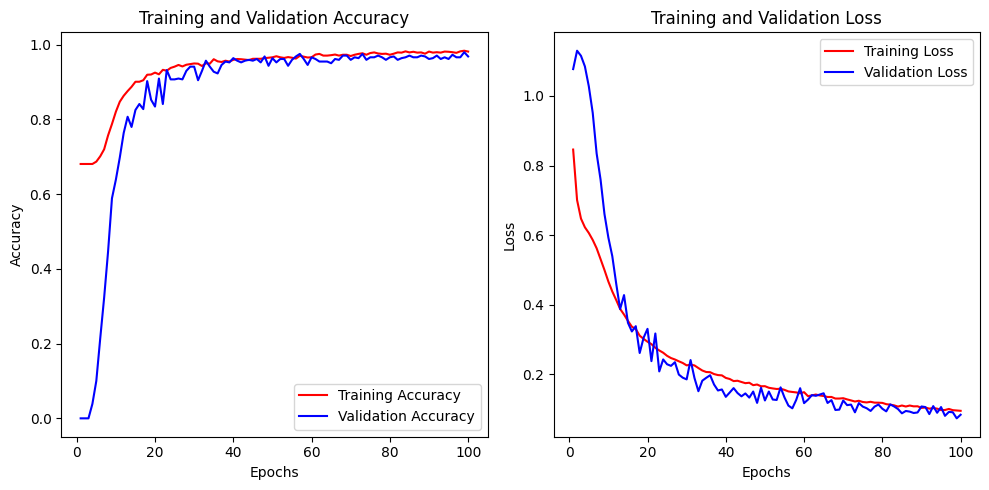

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
def preprocessText(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'[\u2070-\u209F\u00B2-\u00B3\u00B9-\u00BF\u02B0-\u036F\u1AB0-\u1AFF\u2090-\u2094]+', '', text)
    text = emoji.demojize(text)
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'[^\u0000-\u007F\uD800-\uDBFF\uDC00-\uDFFF]+', '', text)
    return text

In [27]:
def preprocessToken(text):
    # remove stop words
    text = remove_stopwords(text, stopwords)

    text = stemmer.stem(text)
    
    # tokenizer
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(text)

    return text

In [28]:
# Test predicting
input_text = "wangi dan bersih"


preprocessedInputText = preprocessText(input_text)
preprocessedInputText = preprocessToken(preprocessedInputText)
print(preprocessedInputText)

inputSequence = pad_sequences(tokenizer.texts_to_sequences([preprocessedInputText]), maxlen=max_length)
predictions = (model.predict(inputSequence) * 5)
print(predictions) 

predictedSentiments = ["Positive Reviews" if pred > 3.0 else "Negative Reviews" for pred in predictions]
predictedSentiments 

wangi bersih
1/1 [==============================] - 0s 246ms/step
[[4.5246954]]


['Positive Reviews']

### Export Model Architecture, Weights, and Tokenizer

In [33]:
model_architecture = model.to_json()
with open('./saved_models/model_architecture.json', 'w') as json_file:
    json_file.write(model_architecture)

model.save_weights('./saved_models/model_weights.h5')

import pickle

with open('./saved_models/tokenizer.pickle', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)